# Calculate freeze-thaw days for NA-CORDEX

This notebook calculates ensemble statistics of annual freeze-thaw days for the NA-CORDEX dataset and saves the results in NetCDF format.

All the data come from the 50-km (NAM-44i) simulations.  Freeze-thaw days are days when the minimum temperature is below -1C, and the maximum temperatre is above 0C.  We calculate freeze-thaw days from daily data, then sum them over years.

The runs are divided into three ensembles: the RCP4.5 runs, the corresponding RCP8.5 runs, and the RCP8.5 runs that don't have a matching RCP4.5 run.  (There are no RCP4.5 runs without a corresponding 8.5 run.)  We then calculate the ensemble min, max, mean, and median at each location for each year.

### TODO items
* apply final masking to ensemble statistics
* add cells (and switch controls) for reading from:
** netcdf on glade
** zarr on stratus object store
** zarr on aws
* use bias-corrected data instead of raw data (not yet available in zarr format)

## Setup

In [1]:
import time
starttime = time.time()

In [2]:
%%time

import xarray as xr
import numpy as np

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from pathlib import Path
import os

import pprint
import json

CPU times: user 715 ms, sys: 211 ms, total: 926 ms
Wall time: 2.77 s


### Use Dask to Speed up Computations

In [3]:
%%time

import dask
from ncar_jobqueue import NCARCluster

## Processes is processes PER CORE.  Memory is total memory split across jobs.

## NA-CORDEX zarr store chunks are around 200 MB, so they should fit easily into the 
## per-core memory allocation.  The total memory request could likely be reduced,
## but you do need a fair amount for overhead of task graph, data buffering, etc.

num_jobs = 30
cluster = NCARCluster(cores=num_jobs, 
                      processes=1, 
                      memory='90GB', 
                      project='P86850057', 
                      walltime="4:00:00")
cluster.scale(jobs=num_jobs)

from distributed import Client
from distributed.utils import format_bytes
client = Client(cluster)
cluster

/glade/work/mcginnis/zarr/miniconda3/envs/pangeo-cordex/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42341 instead
  warnings.warn(


CPU times: user 405 ms, sys: 206 ms, total: 611 ms
Wall time: 1.85 s


In [4]:
## silence warnings about large chunks
dask.config.set({'array.slicing.split_large_chunks': False})

## propagate data attributes during operations ?
## xr.set_options(keep_attrs=True)

## Read in data from zarr stores

We need two different variables (tmin and tmax) and two different scenarios (rcp45 and rcp85) for this analysis, so we need to read from four different zarr stores.  (We're using the concatenated stores, which contain both historical and future data, so we don't need to worry about that.)

We're going to combine those zarr stores into a single xarray `Dataset` in order to simplify the code later on.  We can add two different variables from the same scenario to a single dataset because they have the same structure.  However, the set of RCM-GCM pairings (`member_id` dimension) varies by scenario, so to combine the data from different scenarios, we use `xarray.concat()` to do an outer join and create a new dimension `scen` for the scenario.  The resuting dataset will have a number of empty elements for RCM-GCM pairings that don't exist in both scenarios, but xarray handles that gracefully.

In [5]:
%%time

indir  = '/glade/scratch/bonnland/na-cordex/zarr-publish'

## zarrfiles are named {var}.{scenario}.day.{grid}.{bc}.zarr
zarr = "day.NAM-44i.raw.zarr"

## dict to rename member_id dimension for better plot readability
alias = {'member_id':'model'}

## iterating over scenarios and variables
scenarios = ("rcp45", "rcp85")

dslist = list()


for scen in scenarios:
    ds = xr.Dataset()
    for var in ("tmax","tmin"):
        zarrfile = indir + "/" + var + ".hist-" + scen + "." + zarr
        ds[var] = xr.open_zarr(zarrfile, consolidated=True)[var].rename(alias)
    dslist.append(ds)
    del ds
    
## Need to make scenarios tuple into a numpy array to use it as a coordinate variable
scenarr = np.array(scenarios, dtype="object")
    
ds = xr.concat(dslist, "scen").assign_coords({"scen": scenarr})


CPU times: user 296 ms, sys: 30.1 ms, total: 326 ms
Wall time: 474 ms


In [6]:
# Check that resulting data cube looks reasonable

ds

,Array,Chunk
Bytes,257.82 GB,78.00 MB
Shape,"(2, 15, 55517, 129, 300)","(1, 2, 1000, 65, 150)"
Count,23704 Tasks,5376 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,257.82 GB,78.00 MB
Shape,"(2, 15, 55517, 129, 300)","(1, 2, 1000, 65, 150)"
Count,23704 Tasks,5376 Chunks
Type,float32,numpy.ndarray


### Identify ensembles

In [7]:
## Identify the RCM-GCM pairs in each ensemble while we still have them handily
## separated by scenario in dslist:

ens_rcp45 = set(dslist[0].model.to_dict()["data"])
ens_rcp85 = set(dslist[1].model.to_dict()["data"])
ens_pair = list(ens_rcp85 & ens_rcp45)
ens_solo = list(ens_rcp85 - ens_rcp45)

print("paired:", ens_pair, "\n")
print("solo:", ens_solo, "\n")

## The third case (ens_rcp45 - ens_rcp85) is empty

paired: ['EC-EARTH.RCA4', 'EC-EARTH.HIRHAM5', 'CanESM2.RCA4', 'CanESM2.CRCM5-UQAM', 'MPI-ESM-LR.CRCM5-UQAM', 'CanESM2.CanRCM4'] 

solo: ['MPI-ESM-LR.RegCM4', 'GEMatm-Can.CRCM5-UQAM', 'GFDL-ESM2M.RegCM4', 'MPI-ESM-MR.CRCM5-UQAM', 'HadGEM2-ES.RegCM4', 'GFDL-ESM2M.WRF', 'GEMatm-MPI.CRCM5-UQAM', 'MPI-ESM-LR.WRF', 'HadGEM2-ES.WRF'] 



### Plot a single timestep to check that results look reasonable

CPU times: user 841 ms, sys: 116 ms, total: 957 ms
Wall time: 33.7 s


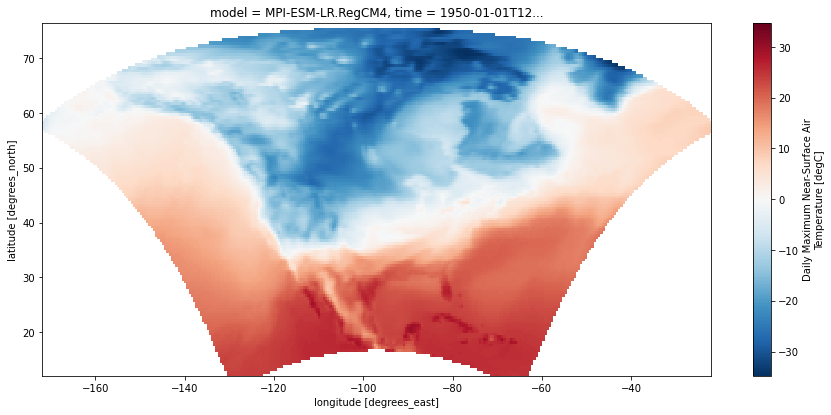

In [8]:
%%time

sim = 'MPI-ESM-LR.RegCM4'
date = "1950-01-01"
scen = "rcp85"

slice = ds['tmax'].sel(model=sim, time=date, scen=scen)

slice.plot(figsize=(15,6.5))

## Calculate freeze-thaw days from tmin & tmax

Different sources use different thresholds for defining freeze-thaw days, so these are adjustable parameters defaulting to -1 and 0 C.

In [9]:
## todo: add units parameter & check units attribute on inputs
## todo: mask missing data in inputs

def freezethaw(tmin, tmax, freeze_temp=-1, thaw_temp=0):
    """
    Calculate freeze-thaw days where tmin < freezing and tmax > freezing
    
    Params:
        tmin, tmax: two xarray DataArrays daily min & max temperatures
        freeze_temp: threshold for tmin; defaults to -1 (units assumed degC)
        thaw_temp: threshold for tmax; defaults to 0 (units assumed degC)
    """
    
    result = (tmin < freeze_temp) & (tmax > thaw_temp)
    
    ## add 0*inputs to cast to float and mask missing value locations
    result = result + tmin * 0 + tmax * 0
    
    ## update attributes - units, longname, stdname
##    result.attr?

    return result    

### Set up calculation

In [10]:
## This step only constructs the task graph.
## The computation doesn't happen until needed or explicitly called.

ds["ftdays"] = freezethaw(ds["tmin"], ds["tmax"])

## check strucutre of result
ds["ftdays"]

,Array,Chunk
Bytes,257.82 GB,78.00 MB
Shape,"(2, 15, 55517, 129, 300)","(1, 2, 1000, 65, 150)"
Count,83066 Tasks,5376 Chunks
Type,float32,numpy.ndarray


### Plot a single timestep to check that results look reasonable

CPU times: user 181 ms, sys: 14 ms, total: 195 ms
Wall time: 1.06 s


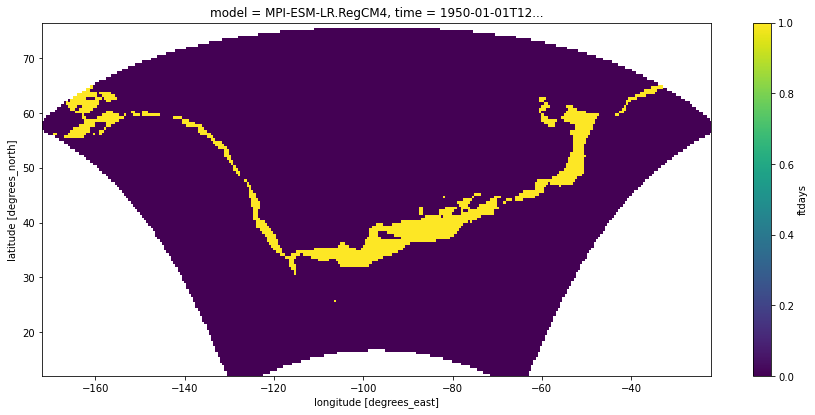

In [11]:
%%time

sim = 'MPI-ESM-LR.RegCM4'
date = "1950-01-01"
scen = "rcp85"

slice = ds["ftdays"].sel(model=sim, time=date, scen=scen)

slice.plot(figsize=(15,6.5))

## Aggregate to yearly totals

Problem: there are two kinds of NA values in the NA-CORDEX dataset, and we want to handle them differently.  

The gridcells that are outside the simulation domain are always missing, and aggregating them should result in an NA value.  However, there are also occasional timesteps that are missing everywhere, and we want to ignore those NA values, because otherwise they will taint the aggregation and result in entire years of missing data.  

The sum() function has a `skipna` argument that toggles whether or not missing values are skipped in summing; when `skipna=True` (the default), it correctly handles the missing days, but we end up with `sum(None)=0` outside the domain.  There's also an argument `min_count` that we should be able to use to detect when we're outside the domain and have no data, but it both triggers a full computation immediately and reliably causes a deadlock partway through.  

This is probably a deep problem that needs to be reported as an xarray bug.  For now, we'll just use `skipna=True` and mask out the always-missing locations afterwards.  (We probably don't *need* to mask the data, but it seems like good practice, especially once we're operating on bias-corrected data where end users might be looking at coastal locations that could fall into an ocean gridbox.)

In [12]:
%%time 

# annftdays = ds["ftdays"].groupby('time.year').sum('time', min_count=180)

# annftdays = ds["ftdays"].groupby('time.year').sum('time', skipna=False)

annftdays = ds["ftdays"].groupby('time.year').sum('time')

annftdays

CPU times: user 811 ms, sys: 43.8 ms, total: 855 ms
Wall time: 843 ms


,Array,Chunk
Bytes,705.89 MB,78.00 kB
Shape,"(2, 15, 152, 129, 300)","(1, 2, 1, 65, 150)"
Count,206330 Tasks,14592 Chunks
Type,float32,numpy.ndarray


### Mask always-missing locations

In [13]:
## Date when no simulations are missing data, safe for all calendars
known_good_date = "1985-01-15"

mask = ds["ftdays"].sel(time=known_good_date)
mask = mask.squeeze().drop("time") * 0
## squeeze to eliminate degenerate dimension, then drop to discard time variable

# mask.sel(scen=scen, model=sim).plot(figsize=(15,6.5))
# mask

annftdays = annftdays + mask

# annftdays

### Plot a single timestep to check that results look reasonable

CPU times: user 413 ms, sys: 21.5 ms, total: 435 ms
Wall time: 1.81 s


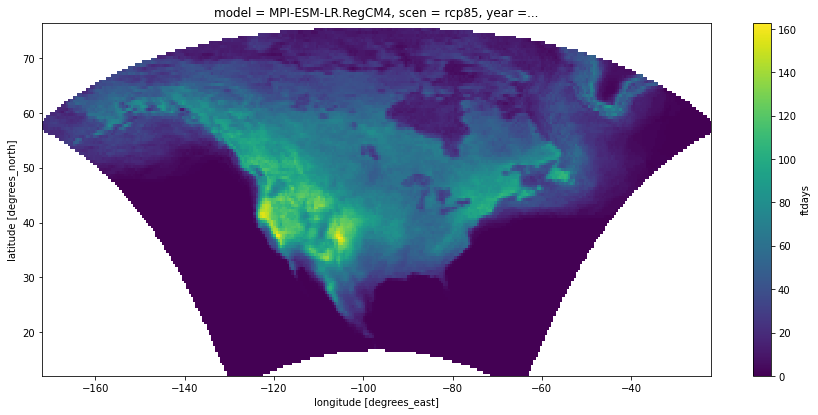

In [14]:
%%time

sim = 'MPI-ESM-LR.RegCM4'
year = 1979
scen = "rcp85"

slice = annftdays.sel(model=sim, year=year, scen=scen)

slice.plot(figsize=(15,6.5))

## Calculate ensemble statistics

Split the data into three ensembles and calculate ensemble min, max, mean, and median.
The ensembles are the rcp45 runs, the corresponding rcp85 runs, and the rcp85 runs that do not have a matching rcp45 run.

Problem: we can't use the `groupby` approach to apply the statisics because xarray does not yet support an appropriate combination of assignment to slices, multidimensional slicing, and indexing with labeled dimension names.  So we have to manually pull things apart into groups, apply the statistics, and then recombine them into a `Dataset` with appropriately labeled axes.  Note again the need to convert the axis labels from tuples into numpy array objects.  

In [15]:
ensembles = ("rcp45.pair", "rcp85.pair", "rcp85.solo")
ensarr = np.array(ensembles, dtype="object")

ensd = dict()
## rechunking is needed by the quantile() function below
ensd['rcp45.pair'] = annftdays.sel(scen="rcp45", model=ens_pair).squeeze().chunk({"model": -1})
ensd['rcp85.pair'] = annftdays.sel(scen="rcp85", model=ens_pair).squeeze().chunk({"model": -1})
ensd['rcp85.solo'] = annftdays.sel(scen="rcp85", model=ens_solo).squeeze().chunk({"model": -1})


stats = ("min","max","mean","p50")
statarr = np.array(stats, dtype="object")

elist = list()

for e in ensembles:
    etemp = list()

    ## If we had a median() fn, we could probably use a loop here, but we only have quantile(q)
    etemp.append(ensd[e].min("model"))
    etemp.append(ensd[e].max("model"))
    etemp.append(ensd[e].mean("model"))
    etemp.append(ensd[e].quantile(q=0.5, dim="model"))

    elist.append(xr.concat(etemp, "stat", coords="minimal").assign_coords({"stat": statarr}))
    ## dropping non-uniform dimensions like scen and quantile via coords="minimal" is required 
    
    
estats = xr.concat(elist, "ensemble").assign_coords({"ensemble":ensarr})

estats = estats.drop(("quantile", "scen"))  ## still need to drop vars for dropped coords

estats

,Array,Chunk
Bytes,564.71 MB,78.00 kB
Shape,"(3, 4, 152, 129, 300)","(1, 1, 1, 65, 150)"
Count,313210 Tasks,7296 Chunks
Type,float64,numpy.ndarray


### Plot some test results

CPU times: user 1.26 s, sys: 62.5 ms, total: 1.32 s
Wall time: 5.13 s


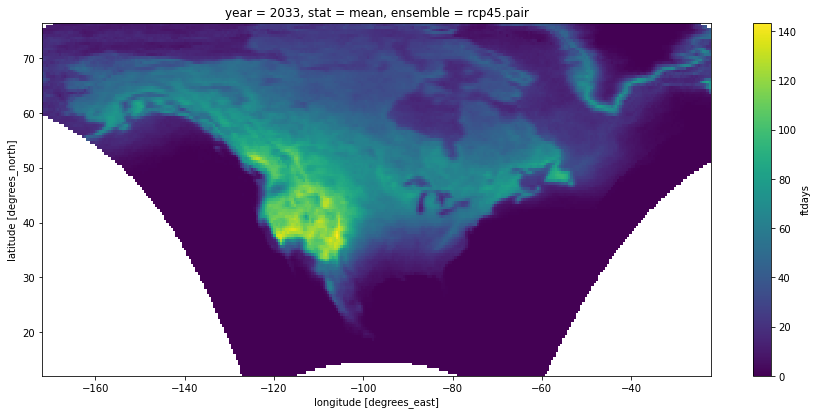

In [16]:
%%time

estats.sel(ensemble="rcp45.pair", stat='mean', year=2033).plot(figsize=(15,6.5))

In [17]:
## NOTE!  Need to re-mask based on always-missing data from *ALL* runs
## Otherwise, stats in some locations near domain bdy may be based on only 1 or 2 models

## Write results to netcdf

Note: at the moment, the input zarr stores only have dataset-level metadata, and no variable-level metadata, so we'll just do the minimum and do it by hand.

Normally we'd want to copy attributes at various stages in the calculation to get them to carry through, but in this case, we won't bother.

In [18]:
%%time

outdir = '/glade/scratch/mcginnis/deloitte/canada/zarr/'  ## note trailing slash

estats.attrs["units"] = "days"
estats.attrs["long_name"] = "freeze-thaw days"

for e in ensembles:
    for s in stats:
        
        outfile = "ftdays."+s+"."+e+".ann.NAM-44i.raw.nc"
        out = estats.sel(ensemble=e, stat=s).to_dataset()
        out.attrs["title"] = "NA-CORDEX raw NAM-44i "+e+" "+s+" freeze-thaw days"
        
        out.to_netcdf(path = outdir + outfile,
                format = "NETCDF4_CLASSIC",
                encoding = {'year' :{'dtype':'float32', '_FillValue':None},
                           'ftdays':{'dtype':'float32', '_FillValue':1e20},
                           'lat'   :{'dtype':'float32', '_FillValue':None},
                           'lon'   :{'dtype':'float32', '_FillValue':None}},
                unlimited_dims = 'year')


CPU times: user 8min 10s, sys: 21 s, total: 8min 31s
Wall time: 14min 43s


In [19]:
estats

,Array,Chunk
Bytes,564.71 MB,78.00 kB
Shape,"(3, 4, 152, 129, 300)","(1, 1, 1, 65, 150)"
Count,313210 Tasks,7296 Chunks
Type,float64,numpy.ndarray


In [20]:
# %%time

## This is how you'd do it using mfdataset to get parallel output, but:
## 1) It doesn't actually save any time over the loop above
## 2) It's not respecting the variable encoding.
## So we stick with the loop above, for now.

## Try it using mfdataset to get parallel output

# outdir = '/glade/scratch/mcginnis/deloitte/canada/zarr/mdf/'  ## note trailing slash


# ## Need to split the DataArray into a list of datasets

# edslist = list()
# outlist = list()

# for e in ensembles:
#     for s in stats:
        
#         outfile = "ftdays."+s+"."+e+".ann.NAM-44i.raw.nc"
#         outlist.append(outdir+outfile)
        
#         outarr = estats.sel(ensemble=e, stat=s)
#         outarr.encoding = {'year' :{'dtype':'float32', '_FillValue':None},
#                           'ftdays':{'dtype':'float32', '_FillValue':1e20},
#                           'lat'   :{'dtype':'float32', '_FillValue':None},
#                           'lon'   :{'dtype':'float32', '_FillValue':None}}
#         out = outarr.to_dataset()
#         out.encoding["unlimited_dims"] = "year"
#         out.attrs["title"] = "NA-CORDEX raw NAM-44i "+e+" "+s+" freeze-thaw days"
#         edslist.append(out)


# xr.save_mfdataset(edslist, 
#                   outlist,
#                   format = "NETCDF4_CLASSIC"
#                  )


## Cleanup

### Release workers

In [21]:
cluster.close()

In [22]:
finishtime = time.time()

In [23]:
print("Total runtime (m):")
(finishtime - starttime)/60

Total runtime (m):


15.658001712958018

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
